### Overview
To assess the impact of climate change on Earth's flora and fauna, it is vital to quantify how human activities such as logging, mining, and agriculture are impacting our protected natural areas. Researchers in Mexico have created the VIGIA project, which aims to build a system for autonomous surveillance of protected areas. A first step in such an effort is the ability to recognize the vegetation inside the protected areas. In this competition, you are tasked with creation of an algorithm that can identify a specific type of cactus in aerial imagery.

<p align="center">
    <img src="http://www.crwphoto.com/Cactus/CactusIMG_7764.jpg" width="600" height="auto">
</p>

### Authors

- Amitrajit Bose
- Anirban Mukherjee

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.image as mpimg

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'train', 'train.csv', 'sample_submission.csv']


In [2]:
!ls ../input/train/train | wc -l

17500


In [3]:
!ls ../input/test/test | wc -l

4000


In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset

In [5]:
data_dir = '../input'
train_dir = data_dir + '/train/train/'
test_dir = data_dir + '/test/test/'

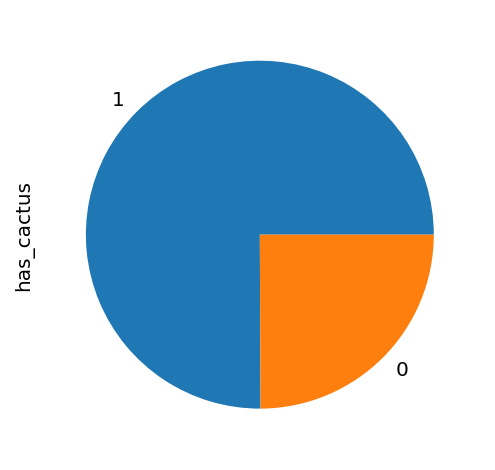

In [6]:
from sklearn.model_selection import train_test_split
labels = pd.read_csv('../input/train.csv')
labels.has_cactus.value_counts().plot.pie()
plt.show()

# dfdict = df.set_index('id')['has_cactus'].to_dict()

### Oversampling

In [7]:
df1 = labels[labels.has_cactus==0].copy()
df2 = df1.copy()
labels = labels.append([df1, df2], ignore_index=True)

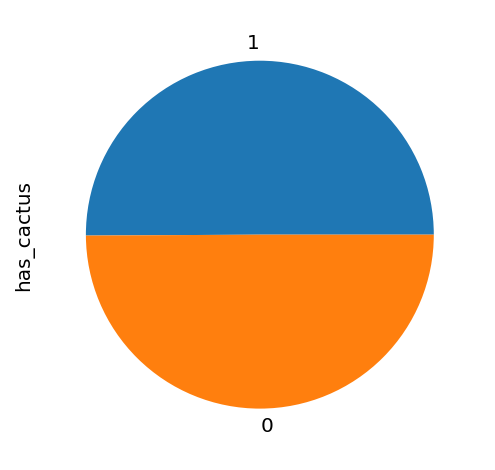

In [8]:
labels.has_cactus.value_counts().plot.pie()
plt.show()

In [9]:
labels.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [10]:
labels.shape

(26228, 2)

### Splitting To Train & Validation Sets

In [11]:
train_df, validation_df = train_test_split(labels, stratify=labels.has_cactus, test_size=0.1)
train_df.shape, validation_df.shape

((23605, 2), (2623, 2))

In [12]:
train_df.head()

,id,has_cactus
25055,b8c4ea77d54a2204f02d6e94561c3309.jpg,0
4902,4642b0af194bfa114591cd760d1cab2a.jpg,0
1164,10cdb7ef072cc48eea19b19e922340de.jpg,1
16812,f5c9d1fabf2fd394367f3d57f62e99f0.jpg,1
1262,11fd27982d88dff2eebe769f7ece4540.jpg,0


In [13]:
validation_df.head()

,id,has_cactus
4889,4613cb16e4c1c17a9103f037f58c72f3.jpg,1
10126,91d5a916645c7e074e26b9593e92a599.jpg,1
13079,bdf49c19ba1489066d76c754731ebf91.jpg,1
18845,4bc86c8e80a1d18bbce147e465d1a1f4.jpg,0
20212,9ae7368b72489e0600a2cc62fa750951.jpg,0


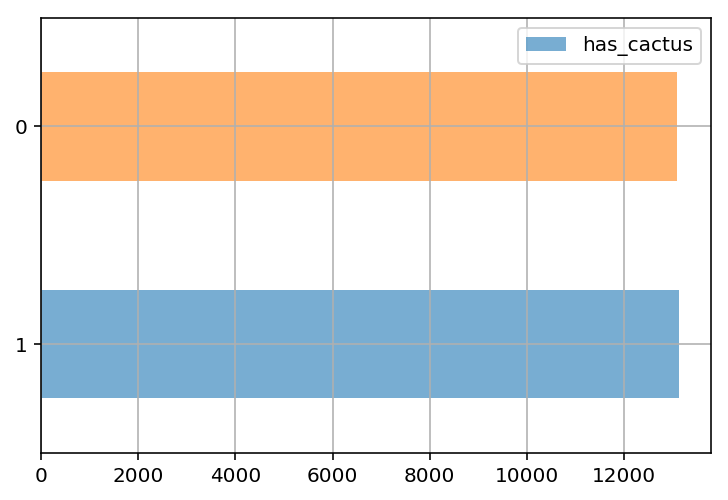

In [14]:
labels['has_cactus'].value_counts().plot.barh(alpha=0.6, grid=True)
plt.legend()
plt.show()

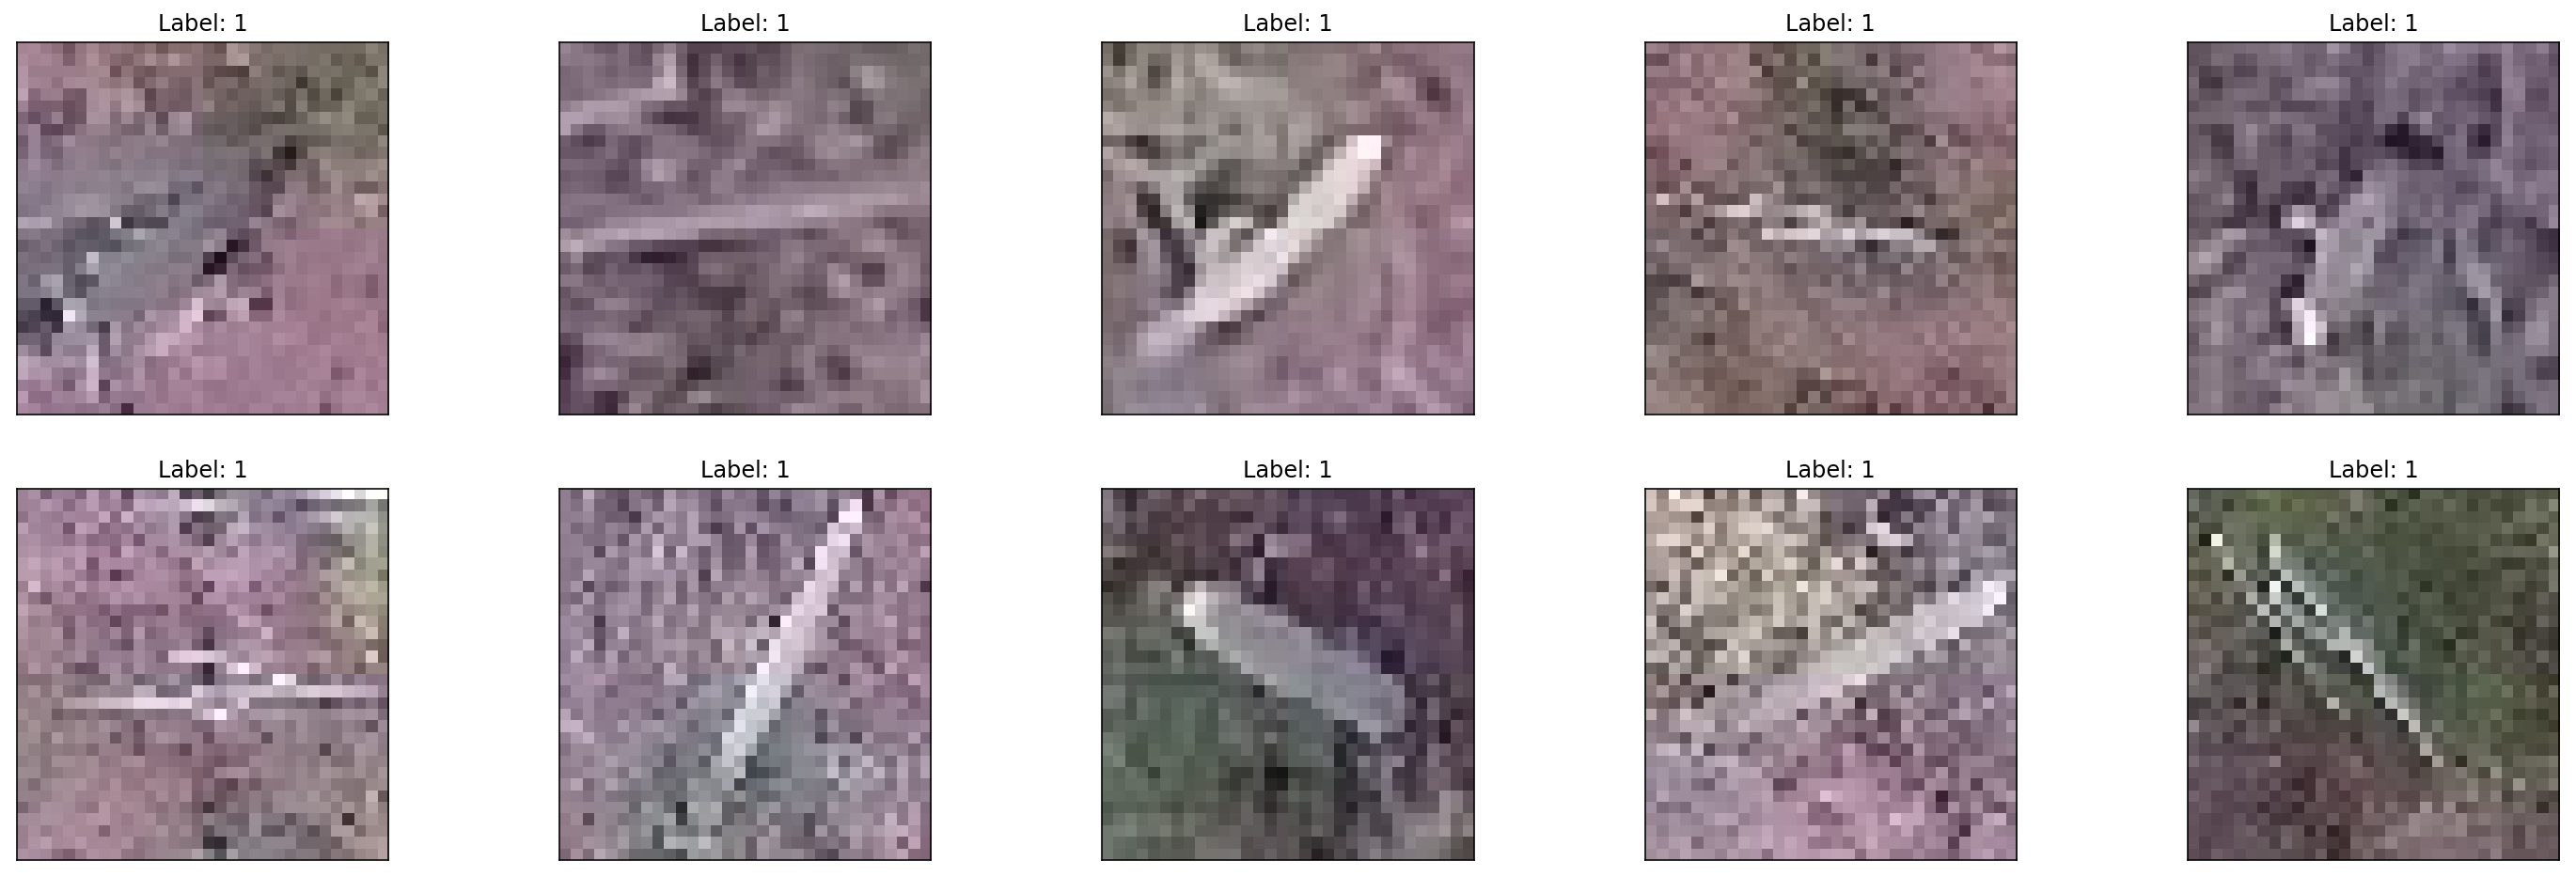

In [15]:
# plot 10 random images from the training dataset
fig = plt.figure(figsize=(25, 8))
train_imgs = os.listdir("../input/train/train")
for idx, img in enumerate(np.random.choice(train_imgs, 10)):
    ax = fig.add_subplot(2, 10//2, idx+1, xticks=[], yticks=[])
    im = mpimg.imread("../input/train/train/" + img)
    plt.imshow(im, cmap="hot")
    lab = labels.loc[labels['id'] == img, 'has_cactus'].values[0]
    ax.set_title(f'Label: {lab}')

### Custom Helper Class For Dataloading

In [16]:
class CactusData(Dataset):
    def __init__(self, df, data_dir, transform):
        super().__init__()
        self.df = df
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):       
        img_name = self.df.id.iloc[index]
        label = self.df.has_cactus.iloc[index]
        
        img_path = os.path.join(self.data_dir, img_name)
        image = mpimg.imread(img_path)
        image = self.transform(image)
        return image, label

In [17]:
epochs = 10
batch_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data Augmentation And Loading

In [18]:
train_transf = transforms.Compose([transforms.ToPILImage(),transforms.RandomRotation(30),transforms.RandomResizedCrop(224),transforms.RandomHorizontalFlip(),transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
val_transf = transforms.Compose([transforms.ToPILImage(),transforms.Resize(255),transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
# [transforms.ToPILImage(), transforms.ToTensor()]

train_data = CactusData(df = train_df, data_dir = train_dir, transform = train_transf)
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle=False)

val_data = CactusData(df = validation_df, data_dir = train_dir, transform = val_transf)
val_loader = DataLoader(dataset = val_data, batch_size = batch_size, shuffle=False)

full_train_data = CactusData(df = labels, data_dir = train_dir, transform = train_transf)
full_train_loader = DataLoader(dataset = full_train_data, batch_size = batch_size, shuffle=False)

### Model Definition

In [19]:
model = models.densenet161(pretrained=True) # Loading pretrained DenseNet-161

# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2208, 1104)),
                          ('relu1', nn.ReLU()),
                          ('fc2', nn.Linear(1104,512)),
                          ('relu2', nn.ReLU()),
                          ('dropout1',nn.Dropout(0.2)),
                          ('fc3', nn.Linear(512, 256)),
                          ('relu3', nn.ReLU()),
                          ('dropout2',nn.Dropout(0.1)),
                          ('fc4', nn.Linear(256, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /tmp/.torch/models/densenet161-8d451a50.pth
115730790it [00:02, 56726384.97it/s]


In [20]:
criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model = model.to(device)

In [21]:
trainlosses = []
trainaccuracies = []
vallosses = []
valaccuracies = []
print("Default Device:", device)

Default Device: cuda


In [22]:
%%time
# Train model
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Move inputs and labels to default device 
        images, labels = images.to(device), labels.to(device)
        
        # Forward
        logps = model.forward(images)
        loss = criterion(logps, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % len(train_loader) == 0:
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            acc = torch.mean(equals.type(torch.FloatTensor)).item()
            
            trainlosses.append(loss.item())
            trainaccuracies.append(acc)
            
            # Validation For The Corresponding Epoch
            model.eval() # Turning model to evaluation mode
            val_accuracy_epoch = 0 # Val accuracy for this epoch
            val_loss_epoch = 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    log_ps = model.forward(inputs)
                    loss_val = criterion(log_ps, labels)
                    ps_val = torch.exp(log_ps)
                    top_p, top_class = ps_val.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    val_acc = torch.mean(equals.type(torch.FloatTensor)).item()
                    val_loss_epoch += loss_val.item()
                    val_accuracy_epoch += val_acc
            vallosses.append(val_loss_epoch/len(val_loader))
            valaccuracies.append(val_accuracy_epoch/len(val_loader))
            model.train() # Turning model back to train mode
            print ('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}'.format(epoch+1, epochs, loss.item(), acc, vallosses[-1], valaccuracies[-1]))

Epoch [1/10], Train Loss: 0.1982, Train Acc: 0.9623, Val Loss: 0.0749, Val Acc: 0.9795
Epoch [2/10], Train Loss: 0.1568, Train Acc: 0.9434, Val Loss: 0.0467, Val Acc: 0.9847
Epoch [3/10], Train Loss: 0.1064, Train Acc: 0.9623, Val Loss: 0.0469, Val Acc: 0.9833
Epoch [4/10], Train Loss: 0.1461, Train Acc: 0.9245, Val Loss: 0.0443, Val Acc: 0.9829
Epoch [5/10], Train Loss: 0.1189, Train Acc: 0.9623, Val Loss: 0.0496, Val Acc: 0.9829
Epoch [6/10], Train Loss: 0.1204, Train Acc: 0.9434, Val Loss: 0.0461, Val Acc: 0.9829
Epoch [7/10], Train Loss: 0.0631, Train Acc: 0.9811, Val Loss: 0.0427, Val Acc: 0.9844
Epoch [8/10], Train Loss: 0.0603, Train Acc: 1.0000, Val Loss: 0.0393, Val Acc: 0.9855
Epoch [9/10], Train Loss: 0.0354, Train Acc: 1.0000, Val Loss: 0.0384, Val Acc: 0.9855
Epoch [10/10], Train Loss: 0.0702, Train Acc: 0.9623, Val Loss: 0.0367, Val Acc: 0.9859
CPU times: user 13min 17s, sys: 6min 10s, total: 19min 28s
Wall time: 20min 13s


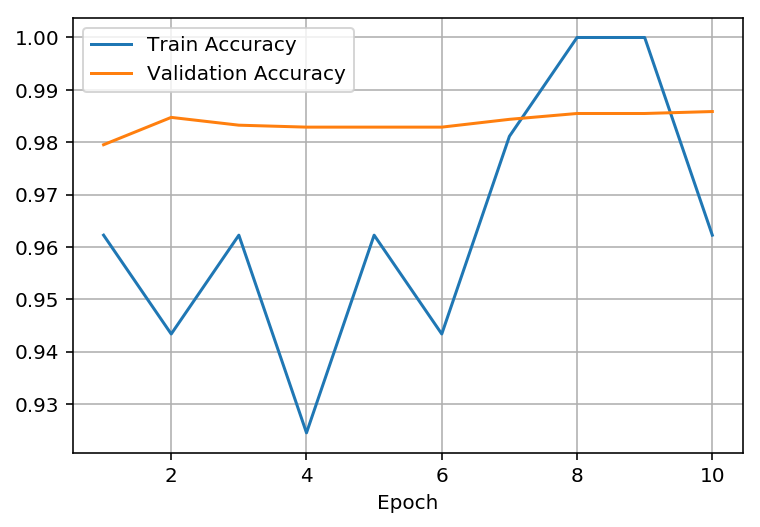

In [23]:
plt.plot([x for x in range(1, epochs+1)], trainaccuracies, label='Train Accuracy')
plt.plot([x for x in range(1, epochs+1)], valaccuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

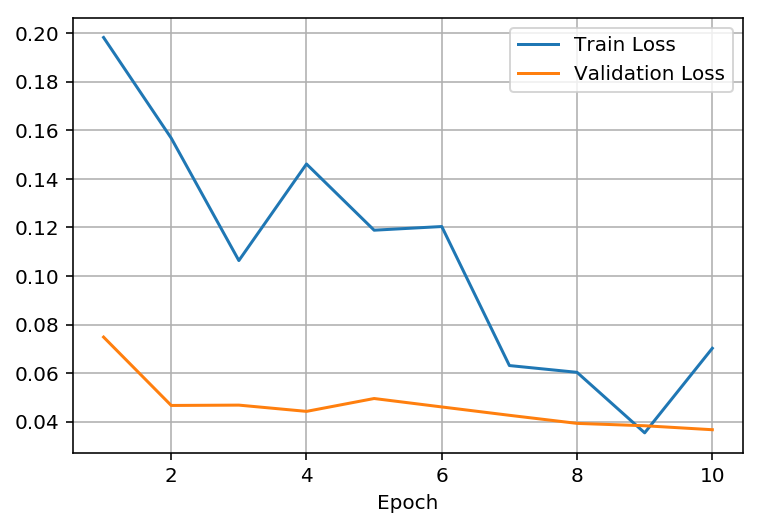

In [24]:
plt.plot([x for x in range(1, epochs+1)], trainlosses, label='Train Loss')
plt.plot([x for x in range(1, epochs+1)], vallosses, label='Validation Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

### Submission

In [25]:
submit = pd.read_csv('../input/sample_submission.csv')
test_data = CactusData(df = submit, data_dir = test_dir, transform = val_transf)
test_loader = DataLoader(dataset = test_data, shuffle=False)

In [26]:
predict = []
model.eval()
with torch.no_grad():
    for batch_i, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        output = model.forward(data)
        top_p, top_class = torch.exp(output).topk(1, dim=1)
        #print(top_p, top_class)
        if top_class.item()==1:
            predict.append(top_p.item()) # probability of presence of cactus
        elif top_class.item()==0:
            predict.append(1 - top_p.item()) # probablity of presence of cactus
        #_, pred = torch.max(output.data, 1)
        #print(_, pred)
        # predict.append(pred.item())
        #pr = output[:,1].detach().cpu().numpy()[0]
        #print(pr)
        # predict.append(pr)
    
#print(predict)
submit['has_cactus'] = predict
submit.to_csv('submission.csv', index=False)

In [27]:
submit.head(10)

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.621936
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.999982
2,001ee6d8564003107853118ab87df407.jpg,0.011123
3,002e175c3c1e060769475f52182583d0.jpg,0.000153
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.997104
5,0038ed6f7417b8275b393307f66cb1e3.jpg,1.000000
6,0059dfa41de4441fc23b9a4b98ba99cb.jpg,0.998206
7,0061bd302d735db829418cb90b4e6040.jpg,0.996498
8,00754573d8c7223e73da553dd43780bd.jpg,0.999342
9,008d9fce71c8e03a4c9cdd15ea908573.jpg,0.002313
